# TensorflowTTS real time E2E-TTS demonstration

This notebook provides a demonstration of the realtime E2E-TTS using TensorflowTTS for Korea (Using KSS dataset)

- Github: https://github.com/TensorSpeech/TensorflowTTS
- Colab for Eng: https://colab.research.google.com/drive/1akxtrLZHKuMiQup00tzO2olCaN-y3KiD?usp=sharing

 참고: https://enchiridion.tistory.com/71
 참고: https://enchiridion.tistory.com/69

##Tacotron2 +MelGAN으로 kSS 스크립트로 음성 생성하기

In [ ]:
!pip install h5py==2.10
!pip install git+https://github.com/repodiac/german_transliterate

In [ ]:
#구글에 연동
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MyDrive


## Install

In [ ]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git
os.chdir("TensorFlowTTS")
!pip install .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

fatal: destination path 'TensorFlowTTS' already exists and is not an empty directory.
Processing /content/drive/MyDrive/MyDrive/TensorFlowTTS
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflowtts to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.7.0 (from tensorflowtts) (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.7.0


## Download pretrained feature generation model


### (a) Tacotron-2 사전학습

In [ ]:
# print("Downloading Tacotron2 model...")
# !gdown --id {"1c8xG8cysHslJRlgB5CYbUnWngEydIfI7"} -O tacotron2-100k.h5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1c8xG8cysHslJRlgB5CYbUnWngEydIfI7
From (redirected): https://drive.google.com/uc?id=1c8xG8cysHslJRlgB5CYbUnWngEydIfI7&confirm=t&uuid=42375dd7-873c-4f3f-a830-a4b74e60d0e4
To: /content/drive/MyDrive/MyDrive/tacotron2-100k.h5
100% 128M/128M [00:02<00:00, 50.2MB/s]


## Download pretrained Vocoder model


### (a) Multi-band MelGAN 사전학습

In [ ]:
# print("Downloading Multi-band MelGAN model...")
# !gdown --id {"1tmmUjKIFekzlQi0-BmEcrib_QP2QbChY"} -O mb.melgan-1000k.h5

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tmmUjKIFekzlQi0-BmEcrib_QP2QbChY
To: /content/drive/MyDrive/MyDrive/mb.melgan-1000k.h5
100% 10.2M/10.2M [00:00<00:00, 14.0MB/s]


## 환경 세팅

In [ ]:
pip install jamo

In [ ]:
pip install Unidecode

In [ ]:
pip install tensorflow-addons

In [ ]:
pip install pypinyin

In [ ]:
pip install g2p-en

In [ ]:
pip install pyopenjtalk

In [ ]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

### (a) Tacotron 2

In [ ]:
tacotron2_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/tacotron2/conf/tacotron2.kss.v1.yaml')
tacotron2 = TFAutoModel.from_pretrained(
    config=tacotron2_config,
    pretrained_path="tacotron2-100k.h5",
    name="tacotron2"
)

### (b) Multi-band MelGAN

In [ ]:
mb_melgan_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/multiband_melgan/conf/multiband_melgan.v1.yaml')
mb_melgan = TFAutoModel.from_pretrained(
    config=mb_melgan_config,
    pretrained_path="mb.melgan-1000k.h5",
    name="mb_melgan"
)

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [ ]:
# kss dataset으로 학습시 각 자,모,특수문자 - 숫자 매핑 dictionary를 가져옵니다.
# 해당 json 파일 또한 학습의 결과입니다.
print("Downloading kss_mapper.json...")
!gdown --id {"1MO1IYKZYUCg3Ve3Gs8iF2pFGCNSFE-da"} -O kss_mapper.json

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MO1IYKZYUCg3Ve3Gs8iF2pFGCNSFE-da
To: /content/drive/MyDrive/MyDrive/kss_mapper.json
100% 2.37k/2.37k [00:00<00:00, 7.06MB/s]


In [ ]:
 # input text를 inference시 숫자로 이뤄진 sequence로 변환할 때 필요합니다.
processor = AutoProcessor.from_pretrained(pretrained_path="./kss_mapper.json")

In [ ]:
# 직접 음성합성을 진행하는 함수입니다.
# text -> mel spectrogram model, vocoder model을 인자로 선택합니다.
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.2], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    audio = vocoder_model.inference(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  # tacotron2면 attention graph도 함께 반환합니다.
  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()
# attention을 시각화해서 보여주는 함수입니다.
# tacotron2의 encoder와 decoder가 어떠한 mapping을 형성하는지 보여줍니다.
def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Encoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Decoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [ ]:
# inference 시 attention graph의 alignment value(색깔, 음량의 세기)의 범위를 지정해준다
# setup window for tacotron2 if you want to try
tacotron2.setup_window(win_front=10, win_back=10)

### (a) Tacotron2 + MB-MELGAN

In [ ]:
input_text = "저는 고객님의 요청을 도와주는 챗봇입니다. 어떤 샌드위치 메뉴를 주문하고 싶으세요? BLT, 미트볼, 햄, 참치, 터키, 베지가 있습니다."

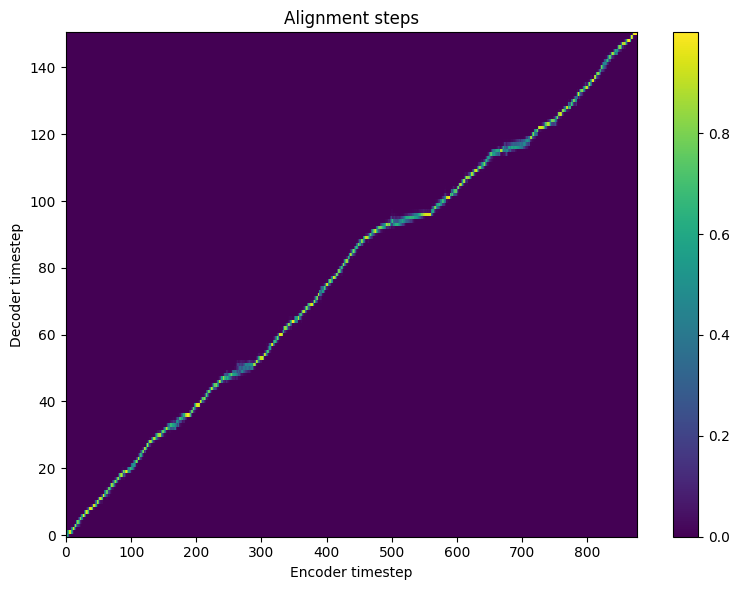

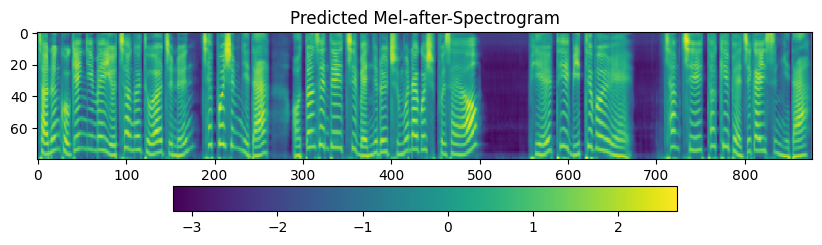

time : 11.412631511688232


In [ ]:
# 시간은 대략 1 ~ 3초 내외로 나온다.
import time
start = time.time()  # 시작 시간 저장
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
ipd.Audio(audios, rate=22050)

생성하기

In [ ]:
import pandas as pd
import time
import soundfile as sf
import os

# CSV 파일에서 데이터 읽기
df = pd.read_csv("vid_list.csv")

# 저장할 폴더 생성
output_folder = "audio_files"
os.makedirs(output_folder, exist_ok=True)

# 각 행을 순회하면서 오디오 생성 및 저장
for index, row in df.iterrows():
    vid_num = row['vid_num']  # 오디오 파일 이름으로 사용할 값
    input_text = row['Text']  # 생성할 오디오의 텍스트

    # 여기에 오디오 생성 및 저장 코드 추가
    start = time.time()  # 시작 시간 저장
    mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")

    # 오디오 저장
    output_filename = os.path.join(output_folder, vid_num)
    sf.write(output_filename, audios, 22050)

    print(f"Generated audio for vid_num {vid_num} in {time.time() - start} seconds")

print("All audio files generated successfully!")


이어하기

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import pandas as pd
import time
import soundfile as sf
import os

# CSV 파일에서 데이터 읽기
df = pd.read_csv("vid_list.csv")

# 저장할 폴더 생성
output_folder = "audio_files"
os.makedirs(output_folder, exist_ok=True)

# 이전에 처리한 마지막 WAV 파일 확인
last_processed_file = None
for file in os.listdir(output_folder):
    if file.endswith(".wav"):
        last_processed_file = file

# 마지막으로 처리한 파일이 있는 경우 해당 파일 다음부터 처리
if last_processed_file:
    last_processed_index = int(last_processed_file.split('.')[0][-4:])
else:
    last_processed_index = 0

# 각 행을 순회하면서 오디오 생성 및 저장
for index, row in df.iloc[last_processed_index:].iterrows():
    vid_num = row['vid_num']  # 오디오 파일 이름으로 사용할 값
    input_text = row['Text']  # 생성할 오디오의 텍스트

    # 여기에 오디오 생성 및 저장 코드 추가
    start = time.time()  # 시작 시간 저장
    mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")

    # 오디오 저장
    output_filename = os.path.join(output_folder, f"{vid_num}.wav")
    sf.write(output_filename, audios, 22050)

    print(f"Generated audio for vid_num {vid_num} in {time.time() - start} seconds")

print("All audio files generated successfully!")
